In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.stattools import adfuller, kpss

from sklearn.metrics import mean_squared_error

from arch import arch_model

import warnings

sns.set()
warnings.filterwarnings("ignore")

In [49]:
def Garch_Variance(data, pre_day, ifACF = False, ifSumm = False, ifVaR = False):
    # ========== Data Preprocess ==========
    data_backup = data.copy()
    data_backup.Date = pd.to_datetime(data_backup.Date)
    data_backup.set_index("Date", inplace = True)
    data = data_backup[["BTC_price_ret", "BTC_price_vol"]]
    
    # ========== Split ==========
    train_df = data.loc[:"2022-07-31"]
    test_df = data.loc["2022-08-01":]

    print("Training Set Shape - ", train_df.shape)
    print("Testing Set Shape - ", test_df.shape)
    
    # ========== IF: plot ACF/PACF ==========
    if (ifACF):
        # Plot ACF
        plt.rcParams["figure.figsize"] = 18, 5

        fig, axes = plt.subplots(1, 2)

        sgt.plot_acf(train_df.BTC_price_ret[1:], zero = False, lags = 40, ax = axes[0])
        # sgt.plot_pacf(train_df.spx_ret[1:].abs(), zero = False, lags = 40, ax = axes[1])
        sgt.plot_acf(train_df.BTC_price_vol[1:], zero = False, lags = 40, ax = axes[1])

        axes[0].set_title("ACF For Returns", size = 24)
        axes[1].set_title("ACF For Squared Returns (Volatility)", size = 24)

        plt.show()
        
        # Plot PACF
        plt.rcParams["figure.figsize"] = 18, 5

        fig, axes = plt.subplots(1, 2)

        sgt.plot_pacf(train_df.BTC_price_ret[1:], zero = False, lags = 40, ax = axes[0])
        # sgt.plot_pacf(train_df.spx_ret[1:].abs(), zero = False, lags = 40, ax = axes[1])
        sgt.plot_pacf(train_df.BTC_price_vol[1:], zero = False, lags = 40, ax = axes[1])

        axes[0].set_title("PACF For Returns", size = 24)
        axes[1].set_title("PACF For Squared Returns (Volatility)", size = 24)

        plt.show()
    
    # ========== Build GARCH model to forcast the variance ==========
    #  Building Dataframe for fitting GARCH model 
    garch_df = pd.DataFrame(data["BTC_price_ret"].shift(1).loc[data.index])
    garch_df.at[train_df.index, "BTC_price_ret"] = train_df["BTC_price_ret"]
    
    # Instantating the model with the full dataset, parameters and specifying the model to be a GARCH model
    model = arch_model(garch_df["BTC_price_ret"][1:], p = 2, q = 1, vol = "GARCH")
    
    # Fitting the model on all the data just before the date specified in "last_obs" argument
    model_results = model.fit(last_obs = test_df.index[0], update_freq = 5)
    # model_results
    
    # Printing the Summary table of the fitted model
    if (ifSumm):
        print(model_results.summary())
    
    # Forcast the variance
    forecasts = model_results.forecast()
    m_mean = forecasts.mean["2022-08-01":]
    v_var = forecasts.variance["2022-08-01":]
    # print(forecasts.simulations)
    
    # ========== FORECASTING ==========
    # Building Predictions Data
    predictions_df = test_df.copy()

    # Predictions
    predictions_df["Predictions"] = model_results.forecast().residual_variance.loc[test_df.index]
    
    # Plot line chart of real value v.s. predicted volatility
    plt.rcParams["figure.figsize"] = 20, 5
    plt.plot(predictions_df["BTC_price_vol"].abs(),label="Autuals")
    plt.plot(predictions_df["Predictions"],label="Predictions")
    plt.title("Actuals vs Predictions for BTC Volatility", size = 24)
    plt.legend()
    plt.show()
    
    # Forecaste the given days
    forc_res = model_results.forecast(horizon=pre_day)
    
    # 计算均方根（RMSE）
    np.sqrt(mean_squared_error(predictions_df["BTC_price_vol"].abs(), predictions_df["Predictions"])) 
    
    # ========== Use VaR index to check out outliers ==========
    if (ifVaR):
        # Get the CDF of GARCH error distribution
        q = model.distribution.ppf([0.01, 0.05])
        print('1% parametric quantile: ',q[0], '5% parametric quantile: ', q[1])

        # Calculate the VaR index
        VaR_parametric = m_mean.values + np.sqrt(v_var).values * q[1]
        VaR_parametric = pd.DataFrame(VaR_parametric, columns = ['5%'], index = v_var.index)

        # Plot the VaR line and data scatter to find the outliers
        plt.plot(VaR_parametric, color = 'red', label = '5% Parametric VaR')
        plt.scatter(v_var.index,test_df.BTC_price_ret, color = 'orange', label = ' BTC Daily Returns' )
        plt.legend(loc = 'upper right')
        plt.show()
    
    return forc_res

Training Set Shape -  (2038, 2)
Testing Set Shape -  (90, 2)


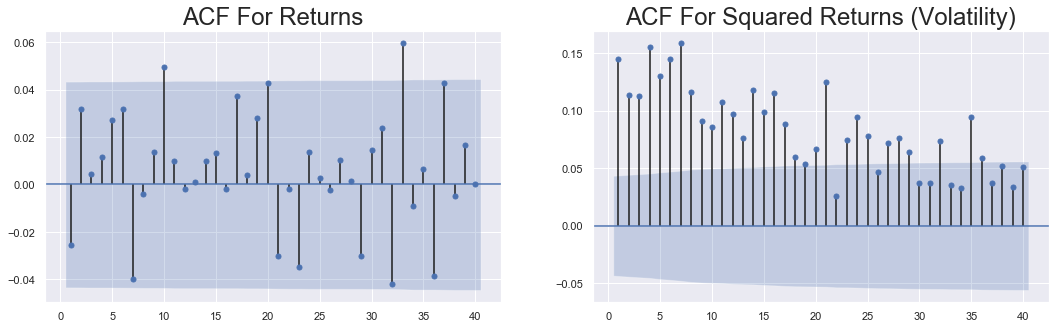

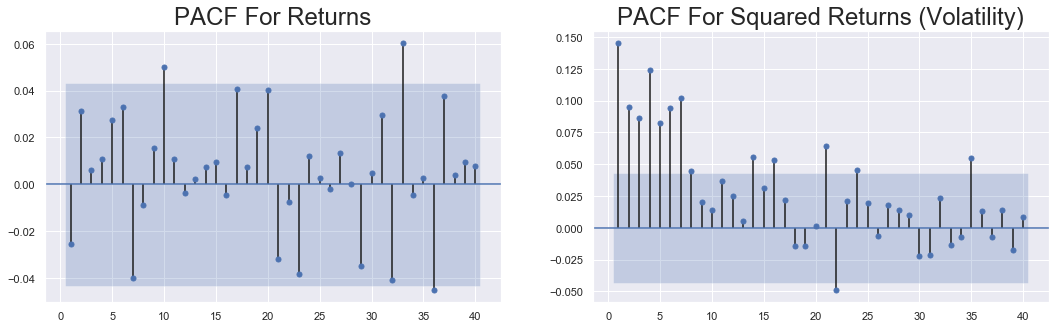

Iteration:      5,   Func. Count:     38,   Neg. LLF: 5677.785545662037
Iteration:     10,   Func. Count:     73,   Neg. LLF: 5677.261968804721
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5677.261617523585
            Iterations: 13
            Function evaluations: 90
            Gradient evaluations: 13
                     Constant Mean - GARCH Model Results                      
Dep. Variable:          BTC_price_ret   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5677.26
Distribution:                  Normal   AIC:                           11364.5
Method:            Maximum Likelihood   BIC:                           11392.6
                                        No. Observations:                 2037
Date:                Fri, Nov 18 2022   Df Residuals:                     2036
Time:          

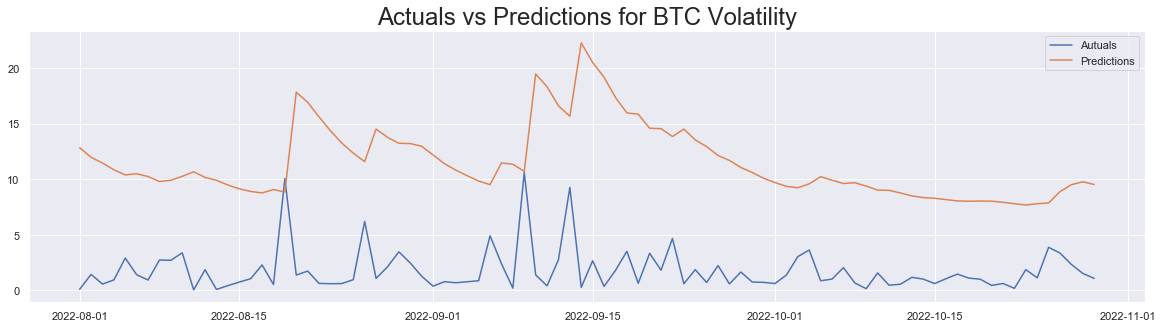

1% parametric quantile:  -2.3263478740408408 5% parametric quantile:  -1.6448536269514729


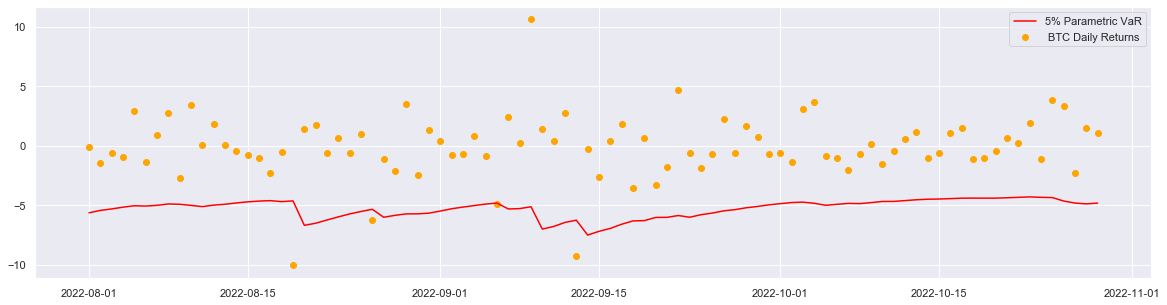

In [51]:
data = pd.read_csv("BTC_data.csv")
garch_model = Garch_Variance(data, 10, True, True, True)